In [1]:
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt
import torch
import sys

# 1. Logistic Regression for Binary Classification (2 points)

In multiclass classification we typically use the exponential model 

$$p(y|\mathbf{o}) = \mathrm{softmax}(\mathbf{o})_y = \frac{\exp(o_y)}{\sum_{y'} \exp(o_{y'})}$$

**1.1. Show that this parametrization has a spurious degree of freedom. That is, show that both $\mathbf{o}$ and $\mathbf{o} + c$ with $c \in \mathbb{R}$ lead to the same probability estimate.**

$$p(y|\mathbf{o}+c) = \mathrm{softmax}(\mathbf{o}+c)_y = \frac{\exp(o_y+c)}{\sum_{y'} \exp(o_{y'}+c)}$$ 

$$ = \mathrm{softmax}(\mathbf{o}+c)_y = \frac{\exp(o_y)\exp(c)}{\sum_{y'} \exp(o_{y'})\exp(c)}$$

$$ = \mathrm{softmax}(\mathbf{o}+c)_y = \frac{\exp(o_y)\exp(c)}{\exp(c)\sum_{y'} \exp(o_{y'})}$$

$$= \frac{\exp(o_y)}{\sum_{y'} \exp(o_{y'})}$$

**1.2. For binary classification, i.e. whenever we have only two classes $\{-1, 1\}$, we can arbitrarily set $o_{-1} = 0$. Using the shorthand $o = o_1$ show that this is equivalent to**

$$p(y=1|o) = \frac{1}{1 + \exp(-o)}$$
$$p(y=-1|o_{-1}) = 1 - \frac{1}{1 + \exp(-o)} = \frac{\exp(-o)}{1 + \exp(-o)} = \frac{1}{1 + \exp(o)} $$
We can rewrite both of the above expressions in this equivalent form:
$$p(y|o) = \frac{1}{1 + \exp(-y*o)} $$

**1.3. Show that the log-likelihood loss (often called logistic loss) for labels $y \in \{-1, 1\}$ is thus given by** 

$$-\log p(y|o) = \log (1 + \exp(-y \cdot o))$$
$$= -\log(\frac{1}{1 + \exp(-y*o)})$$
$$= -\log(1) + \log({1 + \exp(-y*o)})$$
$$= \log({1 + \exp(-y*o)})$$

**1.4. Show that for $y = 1$ the logistic loss asymptotes to $0$ for $o \to \infty$ and to $\infty$ for $o \to -\infty$.** 

As $o \to \infty$, $\exp(-y \cdot o) \to 0$,  therefore, $\log (1 + \exp(-y \cdot o)) \to 0$

As $o \to -\infty$, $\exp(-y \cdot o) \to \infty$,  therefore, $\log (1 + \exp(-y \cdot o)) \to \infty$

# 2. Logistic Regression and Autograd (1 point)

1. Implement the binary logistic loss $l(y,o) = \log (1 + \exp(-y \cdot o))$ in Gluon
1. Plot its values for $y \in \{-1, 1\}$ over the range of $o \in [-5, 5]$.
1. Plot its derivative with respect to $o$ for $o \in [-5, 5]$ using 'autograd'.

I used the mxnet softmax regression example from class and the textbook to get some of the code (more of the import statments and structural framework of the program).

In [2]:
!pip install d2l==0.16.1
!pip install -U mxnet-cu101==1.7.0

Requirement already up-to-date: mxnet-cu101==1.7.0 in /usr/local/lib/python3.6/dist-packages (1.7.0)


In [3]:
# For automatically computing gradients of numpy functions
from mxnet import autograd
# mxnet's version of numpy, which is autograd-friendly
from mxnet import np
# mxnet's neural network + accelerator extensions for numpy
from mxnet import npx
# mxnet's neural network framework (only for data loading here)
from mxnet import gluon
# Tell mxnet to be as numpy-compatible as possible
npx.set_np()

from IPython import display

In [4]:
def bin_log_loss(y,o):
  return np.log(1 + np.exp(-y * o))

Text(0, 0.5, 'Loss when y=1')

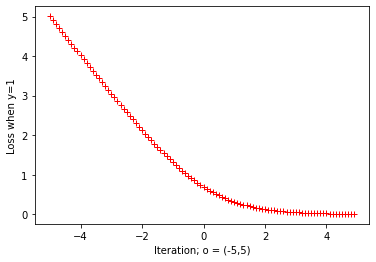

In [5]:
O = np.arange(-5, 5, 0.1)

losses = []

for o in O:
    losses.append(bin_log_loss(1, o))

plt.plot(O,losses, 'r+')
plt.xlabel("Iteration; o = (-5,5)")
plt.ylabel("Loss when y=1")

Text(0, 0.5, 'Loss when y=-1')

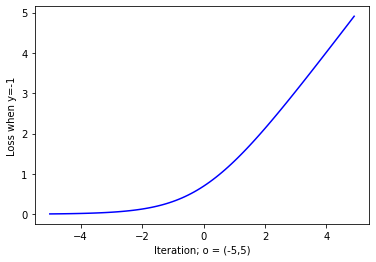

In [6]:
O = np.arange(-5, 5, 0.1)

losses = []

for o in O:
    losses.append(bin_log_loss(-1, o))

plt.plot(O, losses, 'b')
plt.xlabel("Iteration; o = (-5,5)")
plt.ylabel("Loss when y=-1")

Text(0, 0.5, 'Gradient of Loss with respect of o when y=1')

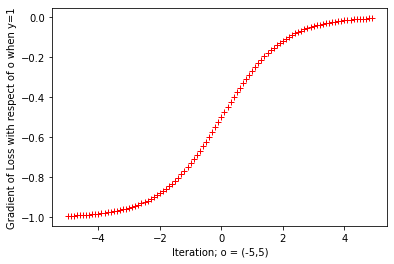

In [7]:
O = np.arange(-5, 5, 0.1)
O.attach_grad()
with autograd.record():
  y = bin_log_loss(1, O)

y.backward()
plt.plot(O,O.grad, 'r+')
plt.xlabel("Iteration; o = (-5,5)")
plt.ylabel("Gradient of Loss with respect of o when y=1")

Text(0, 0.5, 'Gradient of Loss with respect of o when y=-1')

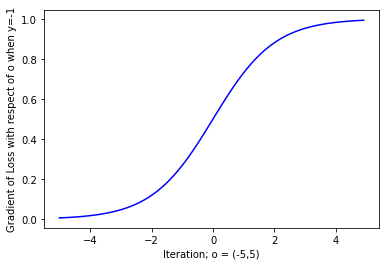

In [8]:
O = np.arange(-5, 5, 0.1)
O.attach_grad()
with autograd.record():
  y = bin_log_loss(-1, O)

y.backward()
plt.plot(O, O.grad, 'b')
plt.xlabel("Iteration; o = (-5,5)")
plt.ylabel("Gradient of Loss with respect of o when y=-1")

# 3. T-shirt vs. Trouser classification (2 points)

1. Implement a logistic regression model on the Fashion MNIST datasets that classifies between t-shirts and trousers, rather than all 10 of the classes. Feel free to use the [softmax regression code from the textbook](http://d2l.ai/chapter_linear-networks/softmax-regression-scratch.html), but use the binary logistic loss you defined above (which assumes that the labels are -1 or 1) rather than a softmax cross-entropy loss. This will require creating custom version of the `d2l.load_data_fashion_mnist` that removes any examples that are not t-shirts or trousers, and maps the labels to -1 and 1.
2. After implementing this model and getting it to work, try changing the learning rate and weight initialization scale. Can you get the model to train more quickly? What values of these hyperparameters result in bad models/poor training dynamics?

*Note*: Don't forget to change the runtime type to "GPU" to speed things up!

In [9]:
def filter_shirt_trousers(sample):
    #if data is t-shirt
    if sample[1] == 0:
      return True
    #if data is t-shirt
    if sample[1] == 1:
      return True
    return False

In [10]:
def transform_shirt_trouser_label(data, label):
    #if data is t-shirt
    if label == 0:
      return data, -1
    #if data is t-shirt
    if label == 1:
      return data, 1
    return data, label  

In [11]:
def load_data_fashion_mnist(batch_size=256, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    dataset = gluon.data.vision
    trans = [dataset.transforms.ToTensor()]
    if resize:
        trans.insert(0, dataset.transforms.Resize(resize))
    trans = dataset.transforms.Compose(trans)
    mnist_train = dataset.FashionMNIST(train=True).transform_first(trans).filter(filter_shirt_trousers)
    mnist_test = dataset.FashionMNIST(train=False).transform_first(trans).filter(filter_shirt_trousers)

    mnist_train = mnist_train.transform(transform_shirt_trouser_label)
    mnist_test = mnist_test.transform(transform_shirt_trouser_label)

    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True,
                                  num_workers=4),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                  num_workers=4))

train_iter, test_iter = load_data_fashion_mnist()

In [12]:
num_inputs = 784
#num_outputs = 10
num_outputs = 2

# Initialize values of parameters in typical numpy syntax
W = np.random.normal(0, 0.01, (num_inputs, num_outputs))
b = np.zeros(num_outputs)
# Tell mxnet we want to keep track of gradients for these parameters
W.attach_grad()
b.attach_grad()

In [13]:
def softmax(X):
    X_exp = np.exp(X)
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [14]:
def net(X):
    # Reshape is necessary because data is originally images
    return softmax(np.dot(X.reshape((-1, W.shape[0])), W) + b)

In [15]:
def bin_log_loss(y_hat, y):
    #a = np.ones(shape=(len(y),))
    #for i in range(len(y)):
    #  if y[i]==-1:
    #    a[i] = 0
    #  else:
    #    a[i] = 1
    o = y_hat[range(len(y_hat)), y]
    #print(o)
    #for i in range(len(y)):
    #  if y[i]==0:
    #    y[i] = -1
    return np.log(1+np.exp(-y* o))
    #return - np.log(y_hat[range(len(y_hat)), y])

In [16]:
def accuracy(y_hat, y):  #@save
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    #print(y_hat)
    #print(y)
    for i in range(len(y_hat)):
      if y_hat[i]==0:
        y_hat[i] = -1
    cmp = y_hat.astype(y.dtype) == y
    #print(float(cmp.astype(y.dtype).sum()))
    return float(cmp.astype(y.dtype).sum())

In [17]:
def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.size)
    return metric[0] / metric[1]

In [18]:
class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [19]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """Train a model within one epoch (defined in Chapter 3)."""
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        with autograd.record():
            y_hat = net(X)
            l = loss(y_hat, y)
        l.backward()
        updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.size)
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [20]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        train_loss, train_acc = train_metrics
        print(f"{epoch + 1}:\ttrain {train_acc*100.0:0.2f}%\ttest {test_acc*100.0:0.2f}%")

In [21]:
lr = 0.1

def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    for param in params:
        param[:] = param - lr * param.grad / batch_size

def updater(batch_size):
    return sgd([W, b], lr, batch_size)

In [ ]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, bin_log_loss, num_epochs, updater)

1:	train 76.41%	test 93.65%
2:	train 93.46%	test 94.60%
3:	train 94.17%	test 94.95%
4:	train 94.57%	test 95.05%
5:	train 94.77%	test 95.35%
6:	train 95.04%	test 95.50%


While I was trying to tune my hyperparameters, I aws having a lot of trouble with the internet and as soon as the program got to the testing phase the run time waould disconnect and I would have to start over and so I wasn't really able to test a lot of different hyper parameter combinations. However, I did achieve ~95% accuracy on the training and test set when the learning rate was 0.1  and the weights initialized to the value it currently is. I image that this ML algorithm would perform badly if the learning rate was much smaller than it is right now (in the sense that the program would be too slow) and too much higher and we might over shoot our optima.

## All of the coding in this this homework was done by me or was taken from the textbook or class example. I talked through problems and checked my results with one of my classmates: Nate Fulmer.